# Part 2: DFA Factor Analysis

All statistics are computed from monthly excess returns unless noted otherwise.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

DATA_PATH_CANDIDATES = [
    Path("assignment-4") / "data" / "dfa_analysis_data.xlsx",
    Path("data") / "dfa_analysis_data.xlsx",
    Path.cwd() / "dfa_analysis_data.xlsx",
]

for candidate in DATA_PATH_CANDIDATES:
    if candidate.exists():
        DATA_PATH = candidate
        break
else:
    raise FileNotFoundError("Could not locate 'dfa_analysis_data.xlsx' in expected locations.")

factors = (
    pd.read_excel(DATA_PATH, sheet_name="factors", parse_dates=["Date"])
    .rename(columns={"Mkt-RF": "MKT"})
    .set_index("Date")
    [["MKT", "SMB", "HML"]]
    .sort_index()
)

factors.head()


,MKT,SMB,HML
Date,,,
1926-07-31,0.0289,-0.0255,-0.0239
1926-08-31,0.0264,-0.0114,0.0381
1926-09-30,0.0038,-0.0136,0.0005
1926-10-31,-0.0327,-0.0014,0.0082
1926-11-30,0.0254,-0.0011,-0.0061


## 1. Factor Statistics

In [2]:
from IPython.display import display

subsamples = {
    "1926-1980": ("1926-07-31", "1980-12-31"),
    "1981-2001": ("1981-01-31", "2001-12-31"),
    "2002-present": ("2002-01-31", factors.index.max()),
}


def summarize_period(frame: pd.DataFrame) -> pd.DataFrame:
    metrics = pd.DataFrame(
        {
            "Mean": frame.mean(),
            "Volatility": frame.std(),
            "Sharpe": frame.mean() / frame.std(),
            "VaR 5%": frame.quantile(0.05),
        }
    )
    return metrics


summary_tables = {
    label: summarize_period(factors.loc[start:end])
    for label, (start, end) in subsamples.items()
}

summary = pd.concat(summary_tables, names=["Period", "Factor"])
summary_display = summary.copy()
summary_display[["Mean", "Volatility", "VaR 5%"]] *= 100
summary_display = summary_display.round({"Mean": 2, "Volatility": 2, "VaR 5%": 2, "Sharpe": 2})

display(summary_display)

nineties_mean = factors.loc["1990-01-31":"1999-12-31"].mean() * 100
nineties_table = nineties_mean.round(2).to_frame(name="Mean (1990-1999)")

display(nineties_table)


Mean  Volatility  Sharpe  VaR 5%
Period       Factor                                  
1926-1980    MKT     0.67        5.92    0.11   -8.41
             SMB     0.28        3.30    0.09   -4.19
             HML     0.42        3.87    0.11   -4.42
1981-2001    MKT     0.65        4.54    0.14   -6.41
             SMB    -0.02        3.39   -0.00   -4.59
             HML     0.54        3.17    0.17   -4.16
2002-present MKT     0.76        4.43    0.17   -7.73
             SMB     0.07        2.55    0.03   -3.92
             HML     0.01        3.07    0.00   -4.15

,Mean (1990-1999)
MKT,1.07
SMB,-0.13
HML,0.00


## 2. Premium Assessment
- Does each factor have a premium in each subsample? 

`MKT` delivers a positive premium in every window; `SMB` is slightly negative in 1981-2001 and only 0.07% per month afterward; `HML` stays positive through 2001 but is flat post-2001.

- Does the premium to the size factor get smaller after 1980? 

Yes, it drops from 0.28% pre-1981 to -0.02% in 1981-2001 and only 0.07% since 2002.

- Does the premium to the value factor get smaller during the 1990s? 

No, the 1990-1999 average of 0.51% exceeds the pre-1981 mean.

- How have the factors performed since the time of the case (2002-present)? 

Market returns strengthened, while size and value premia have been weak and inconsistent.

## 3. Factor Correlations

In [3]:
corr_full = factors.corr()
corr_by_period = {
    label: factors.loc[start:end].corr()
    for label, (start, end) in subsamples.items()
}

corr_tables = {"Full sample": corr_full, **{label: table for label, table in corr_by_period.items()}}
correlations = pd.concat(corr_tables, names=["Period", "Factor"])
correlations.round(3)


MKT    SMB    HML
Period       Factor                     
Full sample  MKT     1.000  0.320  0.228
             SMB     0.320  1.000  0.126
             HML     0.228  0.126  1.000
1926-1980    MKT     1.000  0.374  0.442
             SMB     0.374  1.000  0.313
             HML     0.442  0.313  1.000
1981-2001    MKT     1.000  0.159 -0.530
             SMB     0.159  1.000 -0.445
             HML    -0.530 -0.445  1.000
2002-present MKT     1.000  0.316  0.110
             SMB     0.316  1.000  0.116
             HML     0.110  0.116  1.000

- Full-sample correlations stay between roughly 0.13 and 0.32, confirming the construction goal of low dependence.
- Pre-1981 correlations are higher, especially for `MKT` with `HML`, so the factors were less distinct early on.
- 1981-2001 shows the weakest co-movement, with negative `MKT`/`HML` and `SMB`/`HML` correlations supporting diversification.
- Post-2001 correlations drift modestly positive but remain well below one across all pairs.

## 4. Cumulative Returns

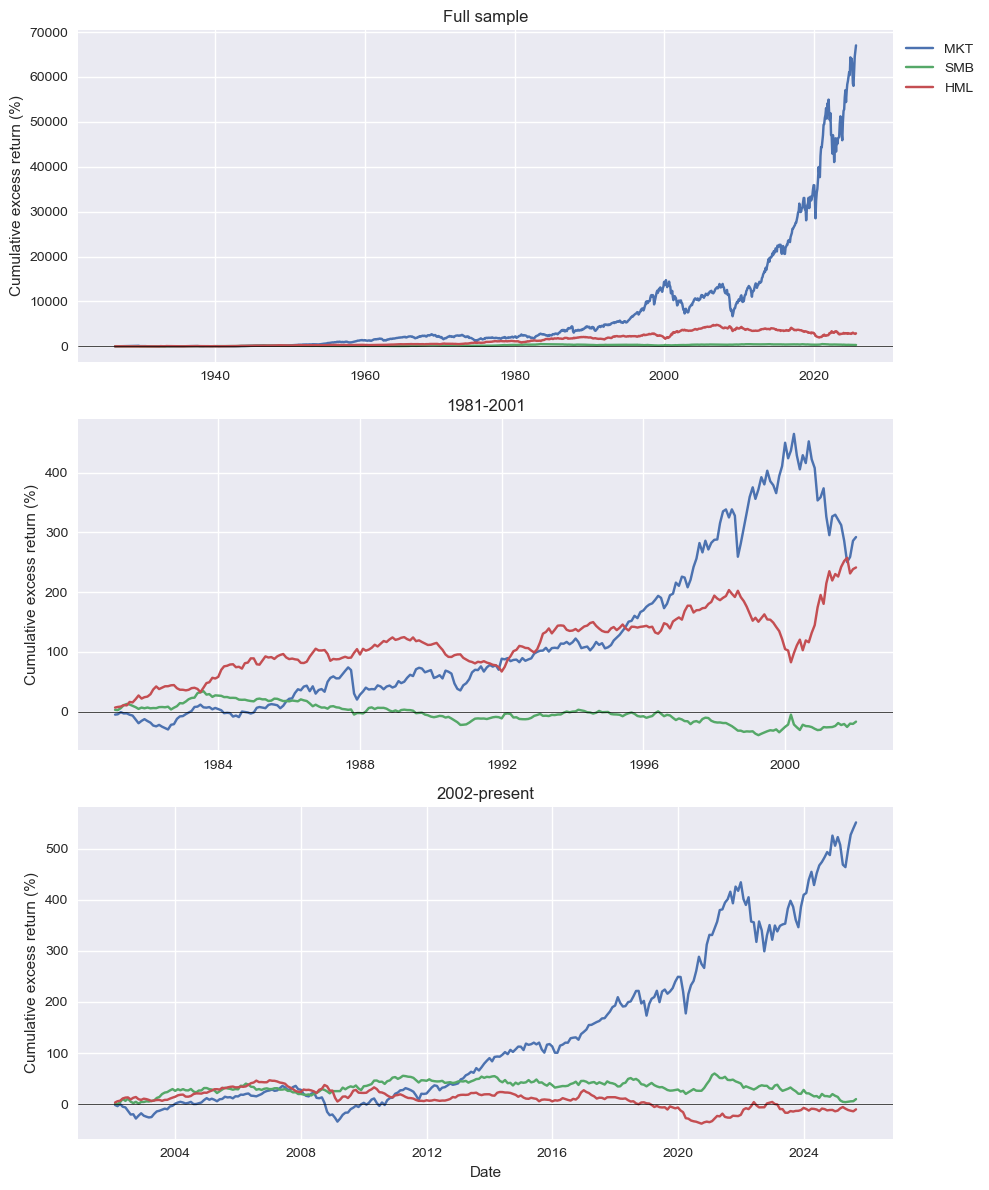

In [4]:
def plot_cumulative(ax, data: pd.DataFrame, title: str) -> None:
    wealth = (1 + data).cumprod() - 1
    ax.plot(wealth.index, wealth * 100)
    ax.set_title(title)
    ax.set_ylabel("Cumulative excess return (%)")
    ax.axhline(0, color="black", linewidth=0.5)


fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)
periods_for_plot = [
    ("Full sample", factors),
    ("1981-2001", factors.loc[subsamples["1981-2001"][0]:subsamples["1981-2001"][1]]),
    ("2002-present", factors.loc[subsamples["2002-present"][0]:subsamples["2002-present"][1]]),
]

for ax, (title, subset) in zip(axes, periods_for_plot):
    plot_cumulative(ax, subset, title)

axes[-1].set_xlabel("Date")
axes[0].legend(factors.columns, loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()


- 1981-2001 plots show all three factors compounding, with `HML` leading and providing diversification when `MKT` stalls.
- Post-2001 cumulative curves highlight a dominant market factor, subdued `SMB`, and a largely flat `HML`.

## 5. Portfolio Guidance
- **1981-2001:** All three factors added value; including size and value alongside the market improved balance.
- **Post-2001:** Market exposure drove performance, while additional size and value tilts diluted returns.
- **Advice:** Keep the market premium as the core, maintain only a modest size tilt, and treat value allocations opportunistically rather than as a constant overweight.